In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv ../.env.local

In [2]:
import base64
from anthropic import Anthropic

import os
from pathlib import Path
import json

from utils import build_message_list, parse_xml_response

In [6]:
client = Anthropic(
    api_key=os.environ.get('ANTHROPIC_API_KEY'),
)

MODEL_NAME = "claude-3-5-sonnet-20240620"

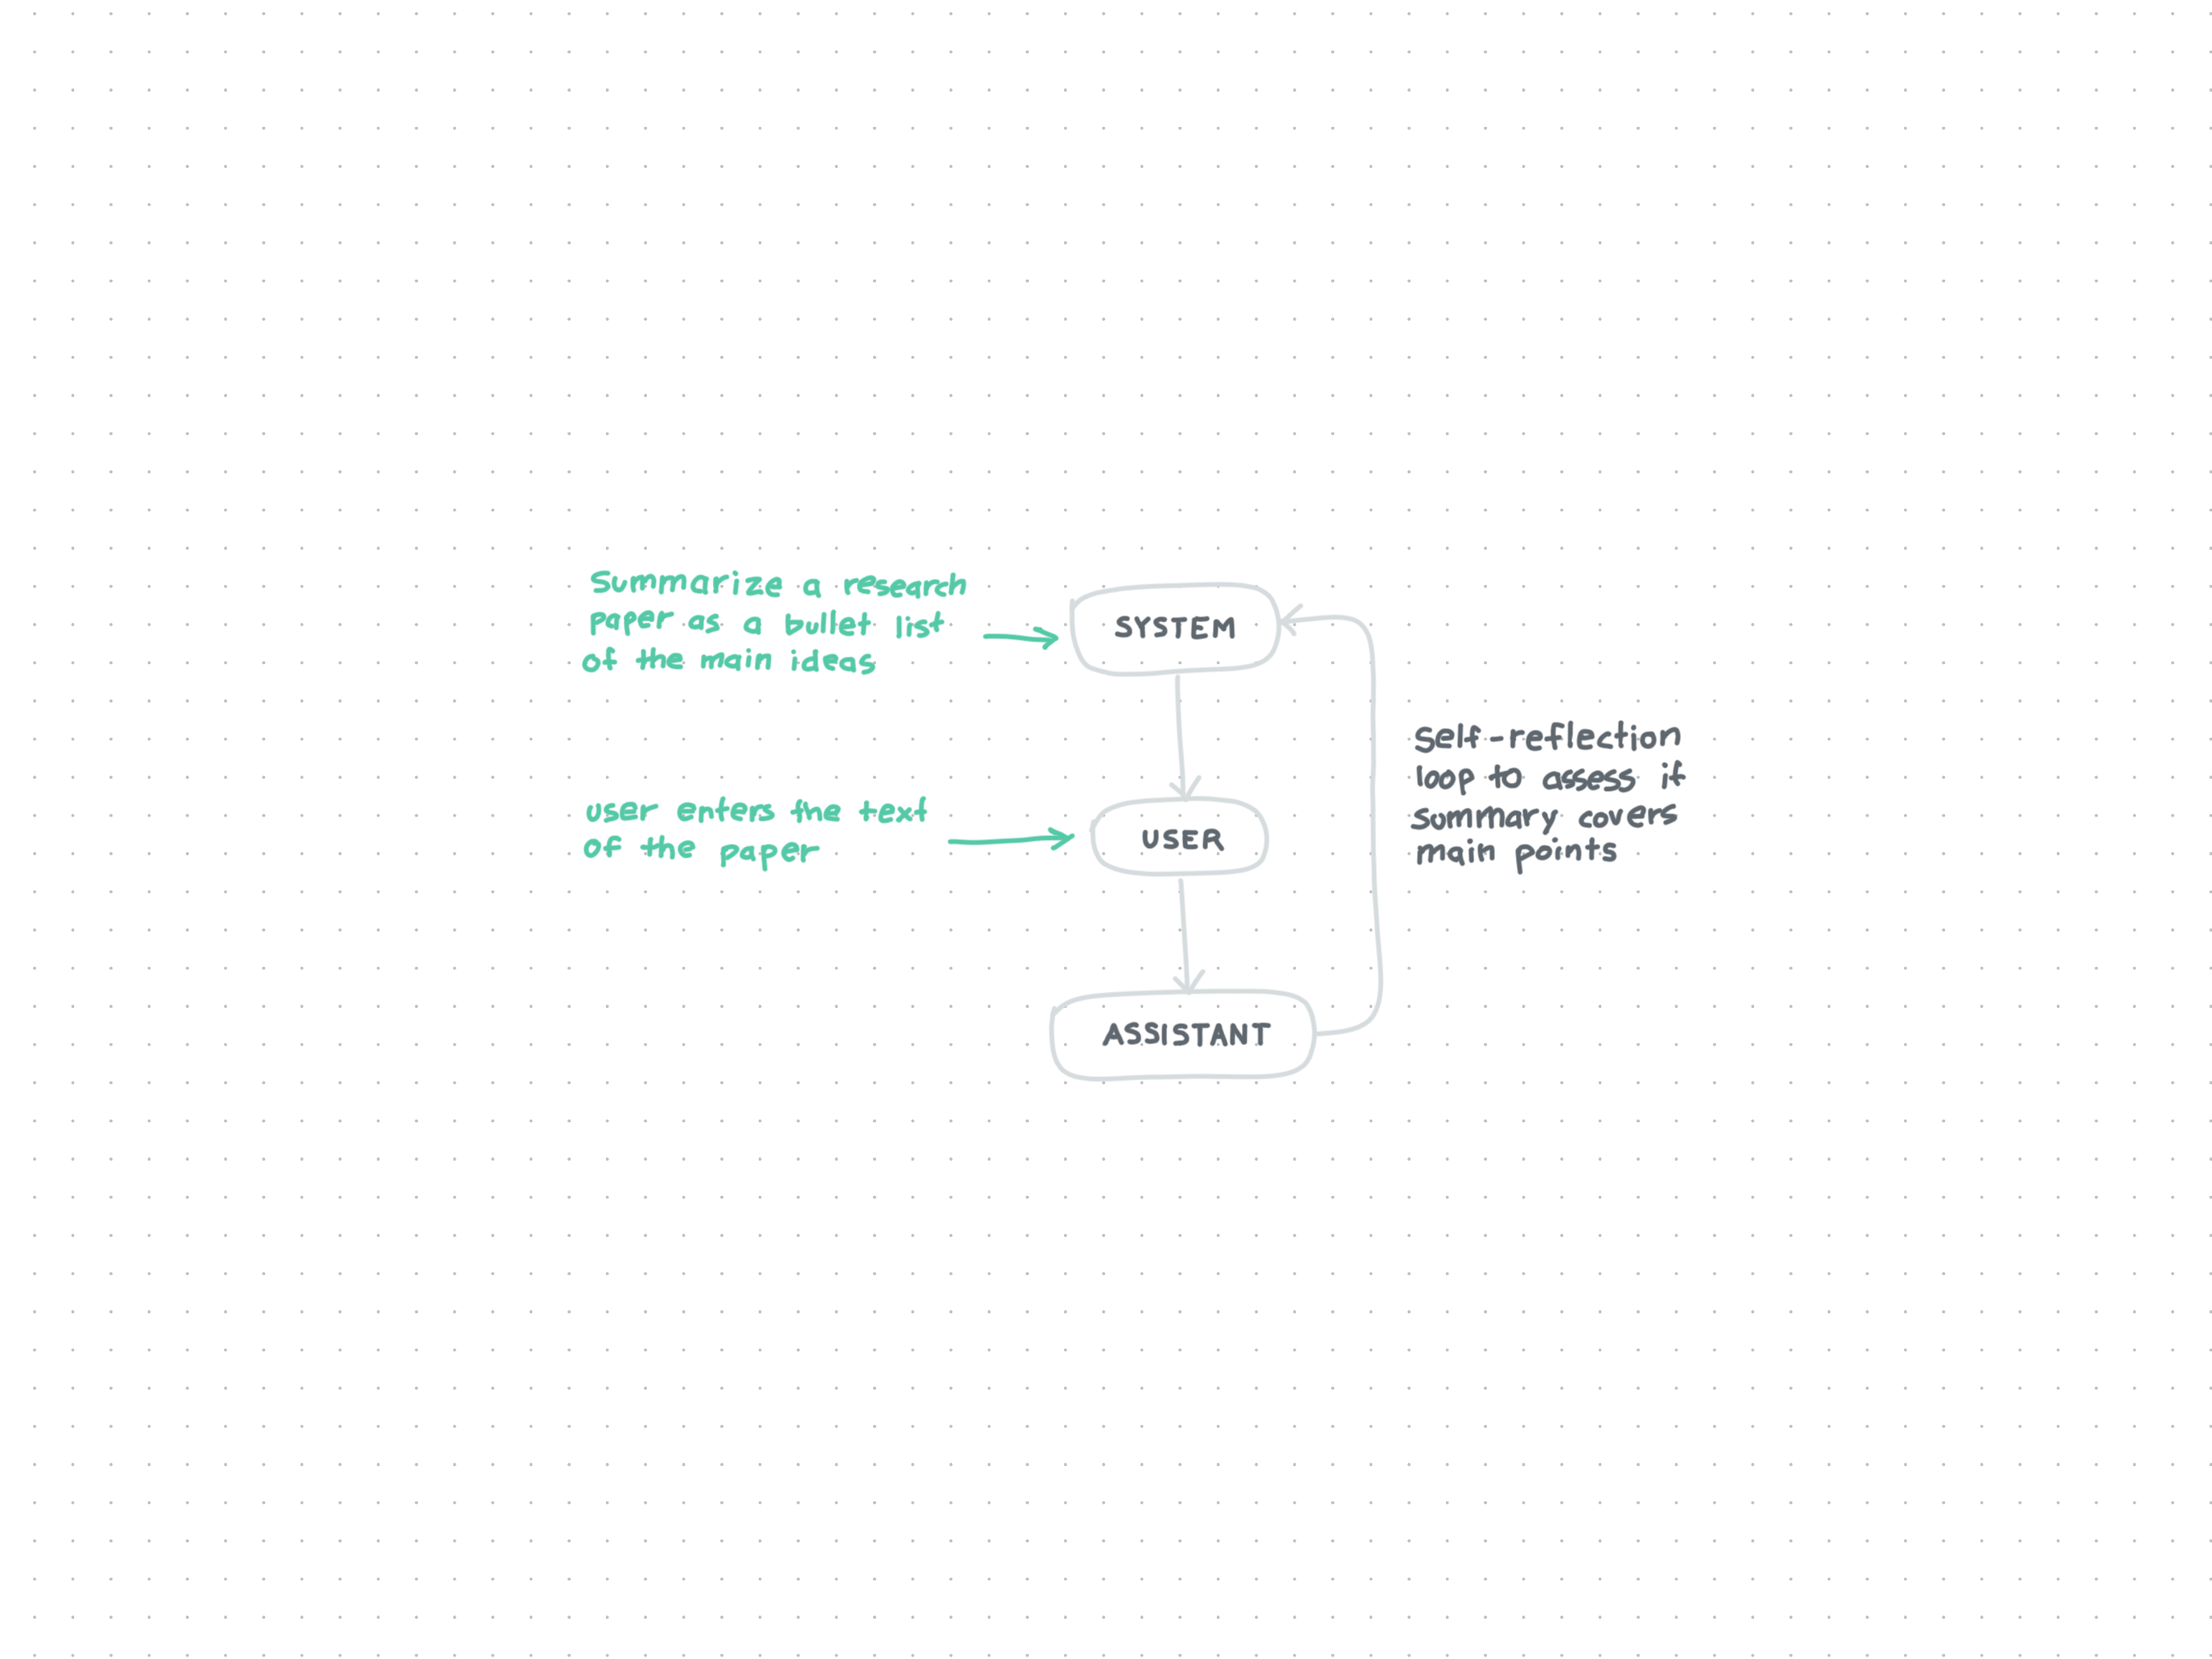

In [7]:
from IPython.display import Image

IMAGE_FILE = '../data/images/reflection-2.png'
Image(filename=IMAGE_FILE) 

In [8]:
system_prompt = '''You are a AI engineer working on a prompt workflow. 
You have been tasked with creating a JSON Canvas diagram that shows the flow of prompts from a handwritten sketch.
Start by creating lists of nodes and edges based on the sketch.
Pay attention to the colors of the text boxes in the sketch. Each color represents a different type of node in the JSON Canvas diagram.
Pay attention to the direction of the arrows in the sketch. The start of the arrow represents the "from" node and the end of the arrow represents the "to" node.
There should be no floating nodes in the JSON Canvas diagram. 
Every node should be connected to at least one other node.
All system prompts MUST connect to a user prompt.
All user prompts MUST connect to an assistant response.
Green metaprompts connect to a system prompt or a user prompt but not both. 
The green arrow should be connected to the prompt that the metaprompt is modifying.
If no assistant response is present, you should add one.
If there is a self-reflection edge, add an edge from that assistant node back to the first prompt node.

Here is an example output with lists of nodes and edges followed by a JSON Canvas diagram:

<nodes>
There is a group node with the label "Cannoli" at the top of the canvas.
There is a text node with the text "Hello world!" at the top left of the canvas.
There is a purple text node with no text at the bottom left of the canvas.
There is a text node with the text "The purple node is a content node. Content nodes can be used to store and display text that can be read or written by you or another node." at the top right of the canvas.
There is a text node with the text "The colorless, green, or yellow node is a call node. Call nodes make a chat completion call to the LLM with the text of the node as a user message." at the bottom right of the canvas.
There is a text node with the text "If a node in a cannoli is floating (no arrows attached) it won't affect the cannoli unless it is formatted in a special way we'll go over later." at the middle left of the canvas.
There is a text node with the text "This is a Cannoli. It's made up of different types of nodes and arrows. Try running it by clicking the Cannoli button in the control ribbon on the left side of your Obsidian window." at the bottom left of the canvas.
There is a text node with the text "Cannolis can be run in several ways: Click the Cannoli ribbon icon If you're on a canvas file, it will be run as a cannoli If you're on a note with a "cannoli" property, the canvas file in that property will be run as a cannoli Run the "Start/Stop cannoli" command in the command palette (functions the same as the ribbon icon) If a canvas file name ends with ".cno", it will have its own run command in the command palette Make an audio recording on a note with a "cannoli" property That recording will be transcribed, replace the reference, and trigger the cannoli defined in the property." at the top right of the canvas.
</nodes>

<edges>
There is an edge connecting the text node with the text "Hello world!" to the empty text node at the bottom left of the canvas.
</edges>

<canvas>
{
	"nodes":[
		{"type":"group","id":"161279baf7763214","x":-174,"y":-160,"width":394,"height":340,"label":"Cannoli"},
		{"type":"text","text":"Hello world!","id":"dc3f9351f787531e","x":-97,"y":-91,"width":250,"height":60},
		{"type":"text","text":"","id":"bc1a550bbb4aac7b","x":-97,"y":60,"width":250,"height":60,"color":"6"},
		{"type":"text","text":"The purple node is a content node. Content nodes can be used to store and display text that can be read or written by you or another node.","id":"f77169b141243e65","x":240,"y":30,"width":420,"height":120},
		{"type":"text","text":"The colorless, green, or yellow node is a call node. Call nodes make a chat completion call to the LLM with the text of the node as a user message.","id":"0af5a453bd4d6ec9","x":240,"y":-110,"width":380,"height":120},
		{"type":"text","text":"If a node in a cannoli is floating (no arrows attached) it won't affect the cannoli unless it is formatted in a special way we'll go over later.","id":"7d005c80299f3674","x":-202,"y":220,"width":461,"height":112},
		{"type":"text","text":"This is a Cannoli. It's made up of different types of nodes and arrows.\n\nTry running it by clicking the Cannoli button in the control ribbon on the left side of your Obsidian window.","id":"24dd96c964700992","x":-147,"y":-400,"width":350,"height":180},
		{"type":"text","text":"Cannolis can be run in several ways:\n\n- Click the Cannoli ribbon icon\n    - If you're on a canvas file, it will be run as a cannoli\n    - If you're on a note with a \"cannoli\" property, the canvas file in that property will be run as a cannoli\n- Run the \"Start/Stop cannoli\" command in the command palette (functions the same as the ribbon icon)\n- If a canvas file name ends with \".cno\", it will have its own run command in the command palette\n- Make an audio recording on a note with a \"cannoli\" property\n\t- That recording will be transcribed, replace the reference, and trigger the cannoli defined in the property.","id":"927cf33512b0dfc1","x":-740,"y":-182,"width":538,"height":402}
	],
	"edges":[
		{"id":"23c2d7dffb49bf75","fromNode":"dc3f9351f787531e","fromSide":"bottom","toNode":"bc1a550bbb4aac7b","toSide":"top"}
	]
}
</canvas>

EVERY text box in the sketch which has a color must be specified in the node's JSON object as follows:

<colors>
Red: {"type":"text", ... , "color":"1"}
Orange: {"type":"text", ... , "color":"2"}
Yellow: {"type":"text", ... , "color":"3"}
Green: {"type":"text", ... , "color":"4"}
Blue: {"type":"text", ... , "color":"5"}
Purple: {"type":"text", ... , "color":"6"}
</colors>'''

user_prompt = '''Create a JSON Canvas from this sketch.'''

message_list = build_message_list(IMAGE_FILE, user_prompt)

response = client.messages.create(
    model=MODEL_NAME,
    max_tokens=2048,
    system=system_prompt,
    messages=message_list,
	temperature=0.0,
)
print(response.content[0].text)

obsidian_vault = Path(os.environ.get('OBSIDIAN_VAULT'))
output_name = Path(IMAGE_FILE).stem
output_file = obsidian_vault / f'{output_name}.canvas'

with open(output_file, 'w') as f:
    json_data = parse_xml_response(response)
    f.write(json.dumps(json_data, indent=4))

print(f'\nCanvas saved to {output_file}')

Based on the sketch provided, I'll create a JSON Canvas diagram with the appropriate nodes and edges. Here's the breakdown:

<nodes>
1. A green text node with the text "Summarize a research paper as a bullet list of the main ideas"
2. A white text node labeled "SYSTEM"
3. A green text node with the text "user enters the text of the paper"
4. A white text node labeled "USER"
5. A white text node labeled "ASSISTANT"
6. A white text node with the text "Self-reflection loop to assess if summary covers main points"
</nodes>

<edges>
1. An edge from the first green node to the "SYSTEM" node
2. An edge from the "SYSTEM" node to the "USER" node
3. An edge from the second green node to the "USER" node
4. An edge from the "USER" node to the "ASSISTANT" node
5. An edge from the "ASSISTANT" node to the "SYSTEM" node (self-reflection loop)
</edges>

Now, I'll create the JSON Canvas diagram:

<canvas>
{
	"nodes":[
		{"type":"text","text":"Summarize a research paper as a bullet list of the main ideas

In [19]:
obsidian_vault = Path(os.environ.get('OBSIDIAN_VAULT'))
output_file = obsidian_vault / 'reflection.canvas'

json_data = parse_xml_response(response)
for node in json_data['nodes']:
    if node['type'] == 'text' and node['text'].lower().strip() == 'assistant':
        node['text'] = ''
        node['color'] = '6'

with open(output_file, 'w') as f:
    f.write(json.dumps(json_data, indent=4))